#                     Fundamentals of Machine Learning - 2022
#                     Report 2 - Classifying with convnets - Data analysis and Baseline
###                          Facundo Sheffield

### Problem:

You will work with an image dataset (see below for details). Your task is two-fold:


1. Build a baseline classification pipeline with a classic machine learning algorithm (i.e. not
based on a neural network) of your choosing, and estimate its classification error. There
should be efforts to improve this error as much as possible.


2. Build a convolutional neural network to classify the same dataset. There should be efforts
to improve its error over the baseline.


Both parts of the problem are mandatory and lacking one of them implies not passing the
course. A bonus point will be given if a pretrained model is implemented. This is in addition
to the hand-crafted convnet, and not in place of it

### Data:

You will be working with the dataset associated to practice 03: faces dict.p.

The dataset is composed by 400 images of 40 different people, each image consisting of
64x64 pixels, each quantized to 256 grey levels and converted to floating point values on the
interval [0, 1]. The target for this database is an integer from 0 to 39 indicating the identity
of the person pictured.

A bonus point will be given if a data augmentation is implemented.

### Data Analysis

Technically, we have already seen the data in practice 03, but we will do a relatively quick recap here.

Lets start by importing the libraries we need and loading the dataset.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [23]:
# Lets load the faces_dict.p file:
with open('faces_dict.p', 'rb') as f:
    faces_dict = pickle.load(f)

Now, because we would like to use data augmentation we will add one channel to the images, so that they can be compatible with modules from keras.

In [24]:
# For data augmentation:
# lets start by adding one channel at the end of the image:

new_val = []
for image in faces_dict['images']:

    new_val.append(np.expand_dims(image, axis=2))

faces_dict.update({'images': np.array(new_val)})

Having done that, lets take a look a the structure of the data:

In [25]:
# Lets understand the structure of the dictionary:
print(faces_dict.keys())
print(faces_dict['data'].shape)
print(faces_dict['images'].shape)
print(faces_dict['target'].shape)

dict_keys(['data', 'images', 'target'])
(400, 4096)
(400, 64, 64, 1)
(400,)


We can clearly see how the images are given as a 64x64 matrix of floats, and also as a 4096 vector. We can also see that the target is a number between 0 and 39, which refers to the identity of the person pictured. Since we also know that there are 10 images per person (from practice 03), we can conclude that the dataset is balanced. This means that we do not have to worry about class imbalance, and that we can use accuracy as a metric to evaluate our models.

Apart from that, we know from a previous practice that there are no NaN values in the dataset and that each value is normalized between 0 and 1, so preprocessing is not necessary at first glance.

That is basically all we can infer from the data without looking at it and based on our previous knowledge, so lets partition it into training and test sets and take a look at some of the images. We will divide the dataset into 25% test and 75% training. Out the training data we will also take 80 samples to use as validation data. This means our primary training set will have only 220 samples. 

We are splitting 25% of the data into test because we want to have a good estimate of the performance of our models on unseen data. Moreover, should our test data be too small, we might end up in a sitution in which we cannot tell if our CNN model is better or worse than our baseline.

In [69]:
# Lets start by separating into train, test and validation:

from sklearn.model_selection import train_test_split
Full_X_train, X_test, Full_y_train, y_test = train_test_split(faces_dict['images'], faces_dict['target'], test_size=100, random_state=42, stratify=faces_dict['target'])
X_train, X_val, y_train, y_val = train_test_split(Full_X_train, Full_y_train, test_size=80, random_state=42, stratify=Full_y_train)

print(f"Training, validation and test data: {len(X_train)}, {len(X_val)}, {len(X_test)}")

Training, validation and test data: 220, 80, 100


Having done the partition we can visualize some of the images:

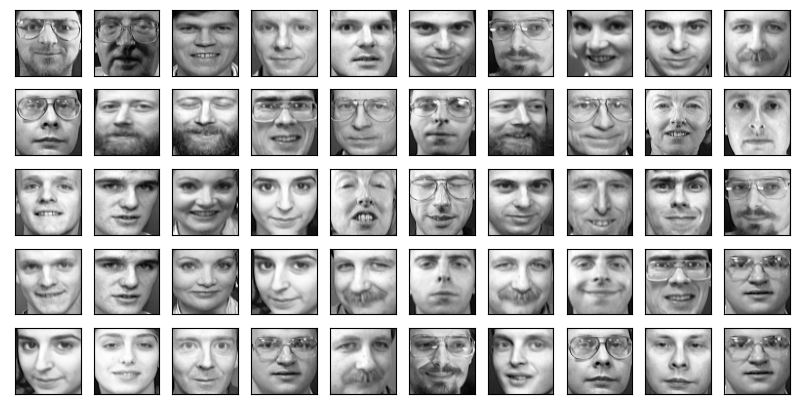

In [32]:
# Lets proceed to visualize random images from the training data:

fig, ax = plt.subplots(5, 10, figsize=(10, 5))
for i, axi in enumerate(ax.flat):
    d = np.random.randint(0, len(X_train))
    axi.imshow(X_train[d], cmap='gray')
    axi.set(xticks=[], yticks=[])
plt.show()

We can see we are dealing with female and male individuals. Also with people with different beards and skin tones, and with or without glasses. Some even have their eyes closed in the picture.

From this plotting test we can confirm that there doesn't seem to be any problems regarding the data itself (no NaNs, no weird values, etc). The biggest issue seems to be the lack of data, so we could proceed to augment it.

### Data Augmentation

Naturally we should not augment the test partition, since we want those images to replicate real data as much as possible. Regarding a potential validation partition, we could augment it after testing it with the training set in order to retrain the model with more data.

For the data augmentation we will use the ImageDataGenerator class from Keras. Since it augments randomly (i.e., some images may not be augmented), we will use a new training set instead of the old one.

In [33]:
# Data augmentation
import random
def add_noise(img):
    '''
    Adds random noise to an image
    from: https://stackoverflow.com/questions/43382045/keras-realtime-augmentation-adding-noise-and-contrast
    '''
    VARIABILITY = 0.1
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 1.)
    return img
    
# Lets augment the data:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=10,  # Mx angle for random rotations
    width_shift_range=0.1, # Max horizontal shift
    height_shift_range=0.1, # Max vertical shift
    shear_range=2, # Shear degree
    horizontal_flip=True,  # Mirror
    preprocessing_function=add_noise, # Adds noise
    # zoom_range = 0.03, # Zoom
    fill_mode='nearest')

datagen.fit(X_train, augment=True, seed=42)
it = datagen.flow(X_train, y_train, batch_size=22)  # iterator, each instance returns a tuple (x, y) of batch_size images and corresponding labels

Lets take a look at the augmented images:

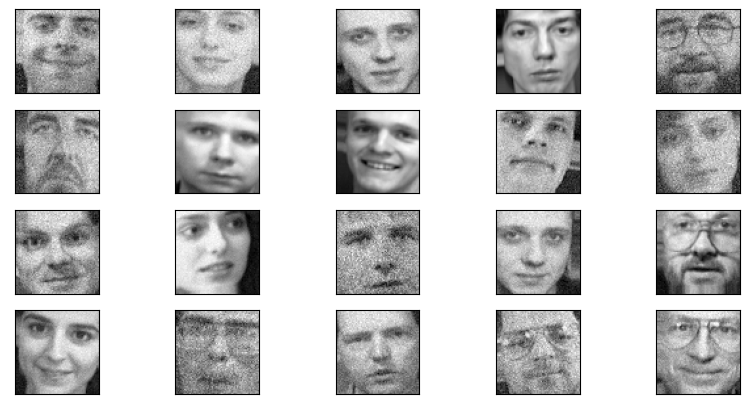

[18  7 11 28 27 10 22  4 35  7 17  7 14 11 13  9 19 37  6 12 38  8]


In [34]:
image_batch, labels = it.next()

# Lets visualize the augmented data:
fig, ax = plt.subplots(4, 5, figsize=(10, 5))

for i, axi in enumerate(ax.flat):
    axi.imshow(image_batch[i], cmap='gray')
    axi.set(xticks=[], yticks=[])
plt.show()
print(labels)

Looks pretty good to me! All the images are still recognizable, and we can see that the augmentation is not too extreme. Now lets consider a new training set with the augmented data.

In [62]:
# Now lets consider a new training set with the augmented data:
X_train_aug, y_train_aug = it.next()
for i in range(89):
    image_batch, labels = it.next()
    X_train_aug = np.concatenate((X_train_aug, image_batch))
    y_train_aug = np.concatenate((y_train_aug, labels))

# Lets check the new training set:
print(f"Augmented training data: {len(X_train_aug)}")

Augmented training data: 1980


The x9 factor in the augmentation is arbitrary. We know that including reflections is essentially a x2 factor in our data, and on top of that we have shear, rotations, gaussian noise and more. Still, it should be noted that augmenting the data too much can lead to overfitting (too many similar images), so we should be careful with this. In this case I used the amount of training data as another hyperparameter to tune.

We can also compare this data with the original at the moment of training the model. Having said that, lets start with our baseline model.

### Baseline

For our baseline model we will use a Random Forest Classifier. This is a classic machine learning algorithm that is easy to implement and that has a decent performance. On top of that, it is robust in terms of scaling and we have already used it in the last report.

Another potential option would be a Support Vector Classifier. In that case one would probably have to apply a standard scaler to the data. This could easily be done through a pipeline though, for example: svc = make_pipeline(StandardScaler(), LinearSVC())   

Apart from that, we could try to use unsupervised learning algorithms such as KMeans or DBSCAN. But since we already have a fully labeled dataset, it is not necessary to use them. Other option would be to reduce the dimensionality of the data before applying our baseline, but since the computational times were not that high, it did not feel necessary.

Having said that, lets get back to our Random Forest. We will apply Gridsearch cross validation to find good hyperparameters for our model.

In [63]:
# Lets start with a random forest classifier:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

clf = RandomForestClassifier(n_estimators=100, random_state=42)

# lets do a grid search to find the best parameters:
from sklearn.model_selection import GridSearchCV
param_grid = {  'n_estimators': [500, 550, 600],
                'max_depth': [17, 18],
                'max_features': [0.0001, 0.0002],
                #'min_samples_split': [2, 5, 10],
                #'min_samples_leaf': [1, 2, 4],
                'bootstrap': [False]  # False because we dont have a lot of data
                }
grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1, verbose=1, return_train_score=True, scoring='accuracy')

# lets reshape the training data:
X_train_aug_RF = X_train_aug.reshape(X_train_aug.shape[0], -1)
X_val_RF = X_val.reshape(X_val.shape[0], -1)
#print(X_train_aug_RF.shape)
grid_search.fit(X_train_aug_RF, y_train_aug)

#print(grid_search.best_estimator_)

#print(grid_search.score(X_val, y_val))

# Lets use the best estimator:
clf = grid_search.best_estimator_
clf.fit(X_train_aug_RF, y_train_aug)
y_pred = clf.predict(X_val_RF)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [64]:
print(grid_search.best_params_)
print(f"Best CV score: {grid_search.best_score_}")
print("Accuracy: ",accuracy_score(y_val, y_pred))

{'bootstrap': False, 'max_depth': 18, 'max_features': 0.0001, 'n_estimators': 600}
Best CV score: 0.81010101010101
Accuracy:  0.9


In [65]:
print(grid_search.cv_results_)

{'mean_fit_time': array([ 6.8476439 ,  7.9554297 ,  8.88278947,  8.54556541,  9.56643004,
       10.37185802,  8.78800707, 10.11228418, 10.52265983,  9.09982295,
        9.99293766,  9.46747651]), 'std_fit_time': array([0.32472519, 0.3849257 , 0.27247868, 0.61914241, 0.12818748,
       0.38071254, 0.11783459, 0.49064172, 0.39420915, 0.26220629,
       0.12486077, 1.09373878]), 'mean_score_time': array([0.89215808, 0.70251722, 0.95232234, 0.54810481, 0.50302734,
       0.70308895, 0.57080965, 0.58237243, 0.64021602, 0.48798127,
       0.61670732, 0.45945373]), 'std_score_time': array([0.24304835, 0.17507408, 0.25644959, 0.04558684, 0.07946017,
       0.08928203, 0.04917142, 0.08695576, 0.03534462, 0.08110263,
       0.11559523, 0.10728059]), 'param_bootstrap': masked_array(data=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
             mask=[False, False, False, False, False, False, False, False,
                   False, False,

We obtain from the validation accuracy a score of 0.9, which is okay but we could probably do much better. 


Note that according to the train scores there appears to be some overfitting in the model. But modifiying the hyperparameters to avoid it ended up giving worse validation scores. So we will leave it as it is.


Something interesting to investigate is to see what happens if we use the non-augmented data:

In [66]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

clf2 = RandomForestClassifier(random_state=42)

# lets do a grid search to find the best parameters:
param_grid = {  'n_estimators': [600, 650],
                'max_depth': [17, 18],
                'max_features': [0.0001, 0.00008],
                #'min_samples_split': [2, 5, 10],
                #'min_samples_leaf': [1, 2, 4],
                'bootstrap': [False, True]  # False because we dont have a lot of data
                }
grid_search = GridSearchCV(clf2, param_grid, cv=5, n_jobs=-1, verbose=1, return_train_score=True, scoring='accuracy')

# lets reshape the training data:
X_train_RF = X_train.reshape(X_train.shape[0], -1)

grid_search.fit(X_train_RF, y_train)

#print(grid_search.best_estimator_)

#print(grid_search.score(X_val, y_val))

# Lets use the best estimator:
clf2 = grid_search.best_estimator_
clf2.fit(X_train_RF, y_train)
y_pred = clf2.predict(X_val_RF)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


In [67]:
print(grid_search.best_params_)
print(f"Best CV score: {grid_search.best_score_}")
print("Accuracy: ",accuracy_score(y_val, y_pred))

{'bootstrap': False, 'max_depth': 17, 'max_features': 0.0001, 'n_estimators': 600}
Best CV score: 0.8818181818181818
Accuracy:  0.975


In [ ]:
grid_search.cv_results_

{'mean_fit_time': array([1.82992725, 1.99248314, 2.20962758, 1.76493435, 1.96902466,
        2.22246714, 2.07681894, 1.98909326, 2.5976058 , 2.24734268,
        2.3619803 , 2.59827552, 2.11338043, 2.53911238, 2.69630566,
        2.26653605, 2.03802786, 2.28274155, 1.57515063, 2.67648225,
        2.80405154, 2.66510863, 2.1311708 , 2.23285408]),
 'std_fit_time': array([0.10237126, 0.06758249, 0.08302932, 0.05393611, 0.13148781,
        0.19043772, 0.23593172, 0.09961371, 0.2915193 , 0.36239865,
        0.13896494, 0.13198493, 0.27647156, 0.28435577, 0.15629799,
        0.19407296, 0.17753015, 0.33499623, 0.21518758, 0.05012586,
        0.10982736, 0.13627846, 0.46841268, 0.44849149]),
 'mean_score_time': array([0.16006551, 0.1875042 , 0.16857867, 0.13406906, 0.15630164,
        0.19153066, 0.16864324, 0.14767423, 0.29009395, 0.16525917,
        0.17651958, 0.29032917, 0.31631551, 0.30181088, 0.24389901,
        0.22393165, 0.30465426, 0.1993031 , 0.23970633, 0.19891725,
        0.301757

Well, it looks like the augmentation was not actually benefitial, since without it we managed to obtain much better results with a validation accuracy of 0.975. Perhaps the augmentation was too extreme or there was too much overfitting. In any case, we will stick to the non-augmented model for the rest of this notebook.

Something to note is that again we see some overfitting in the training scores. But changing the hyperparameters gave worse validation scores just like in the augmented case.

### Final Baseline Model

Now that we have chosen a model, lets train it with the whole training set:

In [73]:
param_grid = {  'n_estimators': [600, 650],
                'max_depth': [17, 18],
                'max_features': [0.0001, 0.00008],
                #'min_samples_split': [2, 5, 10],
                #'min_samples_leaf': [1, 2, 4],
                'bootstrap': [False]  # False because we dont have a lot of data
                }
grid_search = GridSearchCV(clf2, param_grid, cv=5, n_jobs=-1, verbose=1, return_train_score=True, scoring='accuracy')

# lets reshape the training data:
Full_X_train_RF = Full_X_train.reshape(Full_X_train.shape[0], -1)

grid_search.fit(Full_X_train_RF, Full_y_train)

print(grid_search.best_estimator_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
RandomForestClassifier(bootstrap=False, max_depth=17, max_features=0.0001,
                       n_estimators=650, random_state=42)


Finally, lets export the model:

In [77]:
# Lets use the best estimator:
clf2 = grid_search.best_estimator_
clf2.fit(Full_X_train_RF, Full_y_train)


print("Best score: ", grid_search.best_score_)

Best score:  0.93


In [79]:
import pickle
filename = 'RandomForest.pkl'
pickle.dump(clf2, open(filename, 'wb'))